Data Capstone Project: 
Problem Defined=> You're moving into a new neighborhood on the other side of the Toronto city, you want to know which neighborhoods are most simialr to the one you currently live in because you love it so much!
Data Captured=> Using FourSquare API, you'll retrieve geo location data of neighborhoods 
Model=> Unsupervisied KNN

# Web Sraping & Preproccessing

In [168]:
import requests
import pandas as pd 
import numpy as np
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import matplotlib.pyplot as plt

In [99]:
website_url = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text

In [100]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(website_url,'lxml')
print(soup.prettify())

<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
 <head>
  <meta charset="utf-8"/>
  <title>
   List of postal codes of Canada: M - Wikipedia
  </title>
  <script>
   document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgMonthNamesShort":["","Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"],"wgRequestId":"Xg1ldApAICAAAIFQeVAAAAAD","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"List_of_postal_codes_of_Canada:_M","wgTitle":"List of postal codes of Canada: M","wgCurRevisionId":933624196,"wgRevisionId":933624196,"wgArticleId":539066,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Communi

In [101]:
My_table = soup.find('table',{'class':'wikitable sortable'})
My_table

<table class="wikitable sortable">
<tbody><tr>
<th>Postcode</th>
<th>Borough</th>
<th>Neighborhood
</th></tr>
<tr>
<td>M1A</td>
<td>Not assigned</td>
<td>Not assigned
</td></tr>
<tr>
<td>M2A</td>
<td>Not assigned</td>
<td>Not assigned
</td></tr>
<tr>
<td>M3A</td>
<td><a href="/wiki/North_York" title="North York">North York</a></td>
<td><a href="/wiki/Parkwoods" title="Parkwoods">Parkwoods</a>
</td></tr>
<tr>
<td>M4A</td>
<td><a href="/wiki/North_York" title="North York">North York</a></td>
<td><a href="/wiki/Victoria_Village" title="Victoria Village">Victoria Village</a>
</td></tr>
<tr>
<td>M5A</td>
<td><a href="/wiki/Downtown_Toronto" title="Downtown Toronto">Downtown Toronto</a></td>
<td><a href="/wiki/Regent_Park" title="Regent Park">Harbourfront</a>
</td></tr>
<tr>
<td>M6A</td>
<td><a href="/wiki/North_York" title="North York">North York</a></td>
<td><a href="/wiki/Lawrence_Heights" title="Lawrence Heights">Lawrence Heights</a>
</td></tr>
<tr>
<td>M6A</td>
<td><a href="/wiki/North_

In [102]:
column_names = [item.get_text() for item in My_table.find_all('th')]
column_names

['Postcode', 'Borough', 'Neighborhood\n']

In [103]:
contents=[item.get_text() for item in My_table.find_all('td')]
contents

['M1A',
 'Not assigned',
 'Not assigned\n',
 'M2A',
 'Not assigned',
 'Not assigned\n',
 'M3A',
 'North York',
 'Parkwoods\n',
 'M4A',
 'North York',
 'Victoria Village\n',
 'M5A',
 'Downtown Toronto',
 'Harbourfront\n',
 'M6A',
 'North York',
 'Lawrence Heights\n',
 'M6A',
 'North York',
 'Lawrence Manor\n',
 'M7A',
 'Downtown Toronto',
 "Queen's Park\n",
 'M8A',
 'Not assigned',
 'Not assigned\n',
 'M9A',
 "Queen's Park",
 'Not assigned\n',
 'M1B',
 'Scarborough',
 'Rouge\n',
 'M1B',
 'Scarborough',
 'Malvern\n',
 'M2B',
 'Not assigned',
 'Not assigned\n',
 'M3B',
 'North York',
 'Don Mills North\n',
 'M4B',
 'East York',
 'Woodbine Gardens\n',
 'M4B',
 'East York',
 'Parkview Hill\n',
 'M5B',
 'Downtown Toronto',
 'Ryerson\n',
 'M5B',
 'Downtown Toronto',
 'Garden District\n',
 'M6B',
 'North York',
 'Glencairn\n',
 'M7B',
 'Not assigned',
 'Not assigned\n',
 'M8B',
 'Not assigned',
 'Not assigned\n',
 'M9B',
 'Etobicoke',
 'Cloverdale\n',
 'M9B',
 'Etobicoke',
 'Islington\n',
 'M9B

Now we have the data, we will transform it into a pandas dataframe

In [104]:
len(contents)/3

287.0

In [105]:
data=np.reshape(contents, (287,3))

In [106]:
df=pd.DataFrame(data, columns=['PostalCode', 'Borough', 'Neighborhood'])
df.head(5)

,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned\n
1,M2A,Not assigned,Not assigned\n
2,M3A,North York,Parkwoods\n
3,M4A,North York,Victoria Village\n
4,M5A,Downtown Toronto,Harbourfront\n


Couple of preproccessing things to do:


1.Boroughs which have no assigned values should be dropped

2.The neighborhoods have an unnecessary line break

3.The postal codes have multiple neighborhoods

4.Neighborhoods with no assigned value should be assigned borough value

In [107]:
df.shape

(287, 3)

In [108]:
new=df[df['Borough'] != 'Not assigned'] #77 boroughs dropped
new=new.reset_index(drop=True)
new.shape

(210, 3)

In [109]:
new['Neighborhood']=new['Neighborhood'].apply(lambda col: col.split('\n')[0])

In [110]:
new.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,Lawrence Heights
4,M6A,North York,Lawrence Manor


In [111]:
final=new.groupby('PostalCode').agg(lambda i: ','.join(set(i)))

In [112]:
final.reset_index(inplace=True)

In [113]:
final.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Highland Creek,Port Union,Rouge Hill"
2,M1E,Scarborough,"West Hill,Guildwood,Morningside"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


Here we know from the instructions that the index corresponding to Queen's Mary Borough has no neighborhood assigned to it, but to make it more general in case this is not the only exception we run the subsequent cell

In [114]:
final[final['PostalCode'] == 'M9A'].index

Int64Index([93], dtype='int64')

In [115]:
final.loc[final['Neighborhood'] == 'Not assigned','Neighborhood']= final.loc[final['Neighborhood'] == 'Not assigned','Borough'] 

In [116]:
final.shape

(103, 3)

In [117]:
final.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Highland Creek,Port Union,Rouge Hill"
2,M1E,Scarborough,"West Hill,Guildwood,Morningside"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [118]:
latln=pd.read_csv('Geospatial_Coordinates.csv')

In [119]:
latln.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [120]:
latln.rename(columns={'Postal Code': 'PostalCode'}, inplace=True)

In [121]:
final_df=final.merge(latln)

In [122]:
final_df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Port Union,Rouge Hill",43.784535,-79.160497
2,M1E,Scarborough,"West Hill,Guildwood,Morningside",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [123]:
address= 'Toronto, Ontario'
geolocator= Nominatim(user_agent='toronto_explorer')
location=geolocator.geocode(address)
latitude= location.latitude
longitude=location.longitude
print('Toronto latitude is {} and longitude is {}'.format(latitude, longitude))

GeocoderTimedOut: Service timed out

In [ ]:
toronto_map=folium.Map(location=[latitude, longitude], zoom_start=100)
toronto_map

In [ ]:
for borough, neighborhood, lat, long in zip(final_df['Borough'], final_df['Neighborhood'], final_df['Latitude'], final_df['Longitude']):
    label='{},{}'.format(neighborhood, borough)
    label=folium.Popup(label,parse_html=True)
    folium.CircleMarker([lat, long], radius=5, popup=label, color='red', fill=True, fill_color='#3186cc',
                       fill_opacity=0.7, prase_html=False).add_to(toronto_map)
toronto_map


In [124]:
final_df['Borough'].unique()

array(['Scarborough', 'North York', 'East York', 'East Toronto',
       'Central Toronto', 'Downtown Toronto', 'York', 'West Toronto',
       'Mississauga', 'Etobicoke', "Queen's Park"], dtype=object)

In [125]:
dw_toronto=final_df[final_df['Borough'] == 'Downtown Toronto'].reset_index()

In [126]:
dw_toronto.shape

(19, 6)

In [127]:
address= 'Downtown Toronto, Toronto'
geocoder= Nominatim(user_agent='toronto_explorer')
location=geocoder.geocode(address)
latitude=location.latitude
longitude=location.longitude

In [128]:
print('Downtown Toronto latitude and longitude are {}, {}'.format(latitude, longitude))

Downtown Toronto latitude and longitude are 43.6563221, -79.3809161


In [129]:
downtown_toronto_map=folium.Map(location=[latitude, longitude], zoom_start=100)
downtown_toronto_map

In [130]:
for borough, neighborhood, lat, long in zip(dw_toronto['Borough'], dw_toronto['Neighborhood'], dw_toronto['Latitude'], dw_toronto['Longitude']):
    label='{},{}'.format(neighborhood, borough)
    label=folium.Popup(label,parse_html=True)
    folium.CircleMarker([lat, long], radius=5, popup=label, color='red', fill=True, fill_color='#3186cc',
                       fill_opacity=0.7, prase_html=False).add_to(downtown_toronto_map)
downtown_toronto_map


In [131]:
CLIENT_ID = 'RY5QQ3HUOBSHN0KS14RLJTVFKZAADYAQBV0R2BZ4OJ4V22O5' # your Foursquare ID
CLIENT_SECRET = 'TPZFUXLDONC0JPZNX2NZA0Z2VHFMF3IO0RTQDCMVG14FVTMB' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version


In [132]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, limit=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
# create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
# make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
# return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


In [133]:
toronto_venues = getNearbyVenues(names=dw_toronto['Neighborhood'],
                                   latitudes=dw_toronto['Latitude'],
                                   longitudes=dw_toronto['Longitude']
                                  )


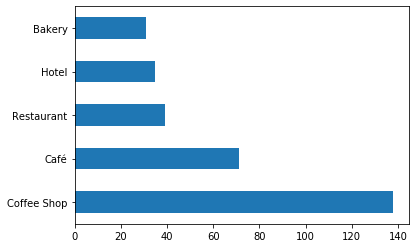

In [247]:
toronto_venues['Venue Category'].value_counts().head(5).plot(kind='barh')

In [202]:
import seaborn as sns

In [155]:
neighborhood_groups=toronto_venues.groupby('Neighborhood').count()

In [195]:
neighborhood_groups.head(2)

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,57,57,57,57,57,57
Central Bay Street,84,84,84,84,84,84


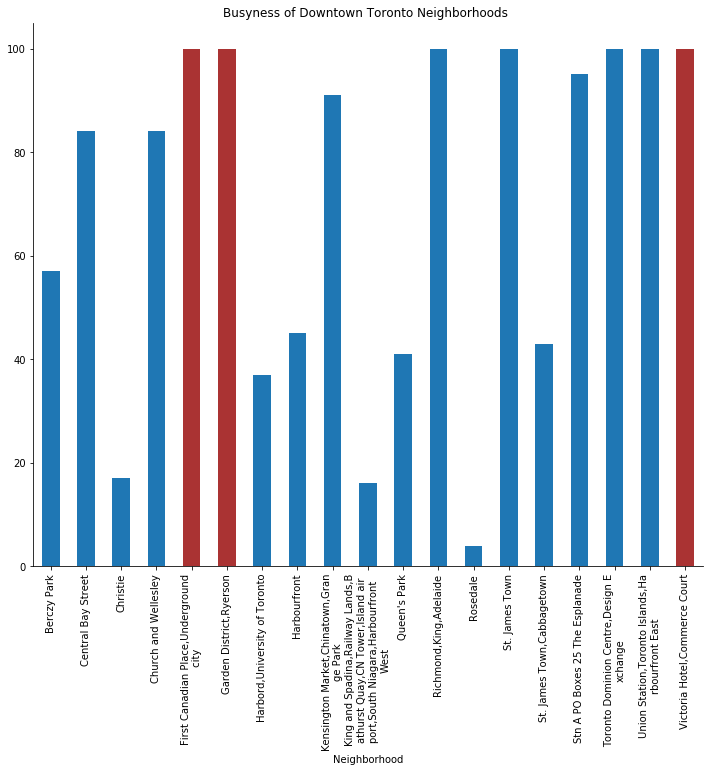

In [248]:
ax=neighborhood_groups.reset_index().plot(figsize=(12,10),kind='bar', x='Neighborhood', y='Venue')
#the busiest neighborhood in downtown toronto 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Busyness of Downtown Toronto Neighborhoods ')
highlight1 = 'First Canadian Place,Underground city'
highlight2= 'Garden District,Ryerson'
highlight3= 'Victoria Hotel,Commerce Court'
pos = neighborhood_groups.index.get_loc(highlight1)
ax.patches[pos].set_facecolor('#aa3333')
pos1 = neighborhood_groups.index.get_loc(highlight2)
ax.patches[pos1].set_facecolor('#aa3333')
pos3 = neighborhood_groups.index.get_loc(highlight3)
ax.patches[pos3].set_facecolor('#aa3333')
max_chars = 32
new_labels = ['\n'.join(label._text[i:i + max_chars ] 
                        for i in range(0, len(label._text), max_chars ))
              for label in ax.get_xticklabels()]

ax.set_xticklabels(new_labels)
ax.legend().set_visible(False)

In [307]:
toronto_venues.head(2)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Rosedale,43.679563,-79.377529,Rosedale Park,43.682328,-79.378934,Playground
1,Rosedale,43.679563,-79.377529,Whitney Park,43.682036,-79.373788,Park


In [310]:
coffee_shops=toronto_venues[toronto_venues['Venue Category'] == 'Coffee Shop'].groupby('Neighborhood').count().drop(['Neighborhood Longitude', 'Neighborhood Latitude', 'Venue Longitude', 'Venue Latitude', 'Venue Category'], axis=1)
coffee_shops.rename(columns={'Venue': 'Coffee Shop Counts'}, inplace=True)
coffee_shops.reset_index(inplace=True)
coffee_shops

,Neighborhood,Coffee Shop Counts
0,Berczy Park,5
1,Central Bay Street,12
2,Christie,1
3,Church and Wellesley,7
4,"First Canadian Place,Underground city",12
5,"Garden District,Ryerson",10
6,"Harbord,University of Toronto",1
7,Harbourfront,7
8,"Kensington Market,Chinatown,Grange Park",4
9,"King and Spadina,Railway Lands,Bathurst Quay,C...",1


In [311]:
coffee_shops=coffee_shops.merge(dw_toronto,left_on='Neighborhood',right_on='Neighborhood')
coffee_shops

,Neighborhood,Coffee Shop Counts,index,PostalCode,Borough,Latitude,Longitude
0,Berczy Park,5,56,M5E,Downtown Toronto,43.644771,-79.373306
1,Central Bay Street,12,57,M5G,Downtown Toronto,43.657952,-79.387383
2,Christie,1,75,M6G,Downtown Toronto,43.669542,-79.422564
3,Church and Wellesley,7,52,M4Y,Downtown Toronto,43.665860,-79.383160
4,"First Canadian Place,Underground city",12,70,M5X,Downtown Toronto,43.648429,-79.382280
5,"Garden District,Ryerson",10,54,M5B,Downtown Toronto,43.657162,-79.378937
6,"Harbord,University of Toronto",1,66,M5S,Downtown Toronto,43.662696,-79.400049
7,Harbourfront,7,53,M5A,Downtown Toronto,43.654260,-79.360636
8,"Kensington Market,Chinatown,Grange Park",4,67,M5T,Downtown Toronto,43.653206,-79.400049
9,"King and Spadina,Railway Lands,Bathurst Quay,C...",1,68,M5V,Downtown Toronto,43.628947,-79.394420


In [282]:
downtown_toronto_map

In [314]:
for count, neighborhood, lat, long in zip(coffee_shops['Coffee Shop Counts'], coffee_shops['Neighborhood'], dw_toronto['Latitude'], dw_toronto['Longitude']):
    label='{},{} Coffee Shops'.format(neighborhood, count)
    label=folium.Popup(label,parse_html=True)
    folium.CircleMarker([lat, long], radius=5, popup=label, color='red', fill=True, fill_color='#3186cc',
                       fill_opacity=0.7, prase_html=False).add_to(downtown_toronto_map)
downtown_toronto_map

In [324]:
toronto_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Rosedale,43.679563,-79.377529,Rosedale Park,43.682328,-79.378934,Playground
1,Rosedale,43.679563,-79.377529,Whitney Park,43.682036,-79.373788,Park
2,Rosedale,43.679563,-79.377529,Alex Murray Parkette,43.678300,-79.382773,Park
3,Rosedale,43.679563,-79.377529,Milkman's Lane,43.676352,-79.373842,Trail
4,"St. James Town,Cabbagetown",43.667967,-79.367675,Cranberries,43.667843,-79.369407,Diner
...,...,...,...,...,...,...,...
1309,Queen's Park,43.662301,-79.389494,SUDS,43.659880,-79.394712,Bar
1310,Queen's Park,43.662301,-79.389494,Tim Hortons,43.659415,-79.391221,Coffee Shop
1311,Queen's Park,43.662301,-79.389494,Tim Hortons,43.658599,-79.388498,Coffee Shop
1312,Queen's Park,43.662301,-79.389494,Understudy Café at Gerstein,43.662308,-79.394098,College Cafeteria


In [328]:
dw_toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
dw_toronto_onehot['Neighborhood']=toronto_venues['Neighborhood']
fixed_columns= [dw_toronto_onehot.columns[-1]] + list(dw_toronto_onehot.columns[:-1])
dw_toronto_onehot=dw_toronto_onehot[fixed_columns]
dw_toronto_onehot.head()

,Yoga Studio,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [350]:
dw_toronto_grouped = dw_toronto_onehot.groupby('Neighborhood').count().reset_index()
dw_toronto_grouped

,Neighborhood,Yoga Studio,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Berczy Park,57,57,57,57,57,57,57,57,57,...,57,57,57,57,57,57,57,57,57,57
1,Central Bay Street,84,84,84,84,84,84,84,84,84,...,84,84,84,84,84,84,84,84,84,84
2,Christie,17,17,17,17,17,17,17,17,17,...,17,17,17,17,17,17,17,17,17,17
3,Church and Wellesley,84,84,84,84,84,84,84,84,84,...,84,84,84,84,84,84,84,84,84,84
4,"First Canadian Place,Underground city",100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
5,"Garden District,Ryerson",100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
6,"Harbord,University of Toronto",37,37,37,37,37,37,37,37,37,...,37,37,37,37,37,37,37,37,37,37
7,Harbourfront,45,45,45,45,45,45,45,45,45,...,45,45,45,45,45,45,45,45,45,45
8,"Kensington Market,Chinatown,Grange Park",91,91,91,91,91,91,91,91,91,...,91,91,91,91,91,91,91,91,91,91
9,"King and Spadina,Railway Lands,Bathurst Quay,C...",16,16,16,16,16,16,16,16,16,...,16,16,16,16,16,16,16,16,16,16


In [386]:
def return_top_venues(row, num_top_venues):
    categories=row.iloc[1:]
    categories_sorted=categories.sort_values(ascending=False)
    return categories_sorted.index.values[0:num_top_venues]
num_top_venues = 15

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
columns

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = dw_toronto_grouped['Neighborhood']
neighborhoods_venues_sorted

#for ind in np.arange(manhattan_grouped.shape[0]):
    #neighborhoods_venues_sorted.iloc[ind, 1:] = return_top_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

#neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
0,Berczy Park,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Central Bay Street,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Christie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Church and Wellesley,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"First Canadian Place,Underground city",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,"Garden District,Ryerson",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,"Harbord,University of Toronto",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Harbourfront,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,"Kensington Market,Chinatown,Grange Park",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,"King and Spadina,Railway Lands,Bathurst Quay,C...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [387]:
#step 3
num_top_venues = 15
for ind in np.arange(dw_toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_top_venues(dw_toronto_grouped.iloc[ind, :], num_top_venues)
neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
0,Berczy Park,Women's Store,Grocery Store,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Discount Store,Diner,Dim Sum Restaurant,Dessert Shop,Department Store,Deli / Bodega,Dance Studio
1,Central Bay Street,Women's Store,Grocery Store,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Discount Store,Diner,Dim Sum Restaurant,Dessert Shop,Department Store,Deli / Bodega,Dance Studio
2,Christie,Women's Store,Grocery Store,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Discount Store,Diner,Dim Sum Restaurant,Dessert Shop,Department Store,Deli / Bodega,Dance Studio
3,Church and Wellesley,Women's Store,Grocery Store,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Discount Store,Diner,Dim Sum Restaurant,Dessert Shop,Department Store,Deli / Bodega,Dance Studio
4,"First Canadian Place,Underground city",Women's Store,Grocery Store,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Discount Store,Diner,Dim Sum Restaurant,Dessert Shop,Department Store,Deli / Bodega,Dance Studio
5,"Garden District,Ryerson",Women's Store,Grocery Store,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Discount Store,Diner,Dim Sum Restaurant,Dessert Shop,Department Store,Deli / Bodega,Dance Studio
6,"Harbord,University of Toronto",Women's Store,Grocery Store,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Discount Store,Diner,Dim Sum Restaurant,Dessert Shop,Department Store,Deli / Bodega,Dance Studio
7,Harbourfront,Women's Store,Grocery Store,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Discount Store,Diner,Dim Sum Restaurant,Dessert Shop,Department Store,Deli / Bodega,Dance Studio
8,"Kensington Market,Chinatown,Grange Park",Women's Store,Grocery Store,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Discount Store,Diner,Dim Sum Restaurant,Dessert Shop,Department Store,Deli / Bodega,Dance Studio
9,"King and Spadina,Railway Lands,Bathurst Quay,C...",Women's Store,Grocery Store,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Discount Store,Diner,Dim Sum Restaurant,Dessert Shop,Department Store,Deli / Bodega,Dance Studio


In [388]:
# set number of clusters
kclusters = 4
dw_toronto_grouped_clustering = dw_toronto_grouped.drop('Neighborhood', axis=1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(dw_toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_ 

array([2, 3, 0, 3, 1, 1, 2, 2, 3, 0, 2, 1, 0, 1, 2, 1, 1, 1, 1])

In [389]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = dw_toronto

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,index,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,...,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
0,50,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529,0,Women's Store,Grocery Store,Electronics Store,...,Donut Shop,Doner Restaurant,Dog Run,Discount Store,Diner,Dim Sum Restaurant,Dessert Shop,Department Store,Deli / Bodega,Dance Studio
1,51,M4X,Downtown Toronto,"St. James Town,Cabbagetown",43.667967,-79.367675,2,Women's Store,Grocery Store,Electronics Store,...,Donut Shop,Doner Restaurant,Dog Run,Discount Store,Diner,Dim Sum Restaurant,Dessert Shop,Department Store,Deli / Bodega,Dance Studio
2,52,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,3,Women's Store,Grocery Store,Electronics Store,...,Donut Shop,Doner Restaurant,Dog Run,Discount Store,Diner,Dim Sum Restaurant,Dessert Shop,Department Store,Deli / Bodega,Dance Studio
3,53,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636,2,Women's Store,Grocery Store,Electronics Store,...,Donut Shop,Doner Restaurant,Dog Run,Discount Store,Diner,Dim Sum Restaurant,Dessert Shop,Department Store,Deli / Bodega,Dance Studio
4,54,M5B,Downtown Toronto,"Garden District,Ryerson",43.657162,-79.378937,1,Women's Store,Grocery Store,Electronics Store,...,Donut Shop,Doner Restaurant,Dog Run,Discount Store,Diner,Dim Sum Restaurant,Dessert Shop,Department Store,Deli / Bodega,Dance Studio


In [390]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [391]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,PostalCode,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
2,M4Y,-79.383160,3,Women's Store,Grocery Store,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Discount Store,Diner,Dim Sum Restaurant,Dessert Shop,Department Store,Deli / Bodega,Dance Studio
7,M5G,-79.387383,3,Women's Store,Grocery Store,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Discount Store,Diner,Dim Sum Restaurant,Dessert Shop,Department Store,Deli / Bodega,Dance Studio
13,M5T,-79.400049,3,Women's Store,Grocery Store,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Discount Store,Diner,Dim Sum Restaurant,Dessert Shop,Department Store,Deli / Bodega,Dance Studio


In [392]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,PostalCode,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
1,M4X,-79.367675,2,Women's Store,Grocery Store,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Discount Store,Diner,Dim Sum Restaurant,Dessert Shop,Department Store,Deli / Bodega,Dance Studio
3,M5A,-79.360636,2,Women's Store,Grocery Store,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Discount Store,Diner,Dim Sum Restaurant,Dessert Shop,Department Store,Deli / Bodega,Dance Studio
6,M5E,-79.373306,2,Women's Store,Grocery Store,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Discount Store,Diner,Dim Sum Restaurant,Dessert Shop,Department Store,Deli / Bodega,Dance Studio
12,M5S,-79.400049,2,Women's Store,Grocery Store,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Discount Store,Diner,Dim Sum Restaurant,Dessert Shop,Department Store,Deli / Bodega,Dance Studio
18,M7A,-79.389494,2,Women's Store,Grocery Store,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Discount Store,Diner,Dim Sum Restaurant,Dessert Shop,Department Store,Deli / Bodega,Dance Studio
